## Apex Legends S15 - **Preprocessing** 

In this section, we’ll transform our cleaned Apex Legends dataset into a ready‑to‑model format by:

- Loading the cleaned player retention dataset
- Auditing data and selecting features for modeling
- Handling missing values (if present)
- Encoding categorical variables (if any)
- Scaling features for model compatibility
- Addressing class imbalance using SMOTE
- Splitting data into training and testing sets
- Saving preprocessed data for downstream modeling


In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [174]:
df = pd.read_csv('ApexPlayerRetention_final.csv', parse_dates=['date'])
print(f"Data shape: {df.shape}")
df.head()

Data shape: (499, 35)


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month
0,2022-11-03,1,broken moon,casual,846.0,S3,no,yes,5.0,1.0,...,0,1,0,0,1,1,0,0,Thursday,2022-11
1,2022-11-03,2,broken moon,casual,498.0,S3,no,yes,12.0,2.0,...,0,0,0,0,0,0,0,0,Thursday,2022-11
2,2022-11-03,3,broken moon,casual,498.0,S3,no,no,3.0,2.0,...,2,0,0,0,0,0,0,0,Thursday,2022-11
3,2022-11-03,4,broken moon,casual,498.0,S3,no,no,4.0,2.0,...,1,0,0,0,0,0,0,0,Thursday,2022-11
4,2022-11-03,5,broken moon,casual,498.0,S3,no,no,8.0,2.0,...,3,0,1,0,0,0,1,0,Thursday,2022-11


In [176]:
# Quality Check
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

# Statistics for numeric columns
print("\nSummary statistics:")
print(df.describe().T)

# Check class distribution for the target variable
print("\nRetention/Churn Distribution:")
print(df['retained'].value_counts())
print("\nProportion:")
print(df['retained'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                499 non-null    datetime64[ns]
 1   game                499 non-null    int64         
 2   map                 499 non-null    object        
 3   match_type          499 non-null    object        
 4   my_duration         499 non-null    float64       
 5   my_rank             499 non-null    object        
 6   premade_squad       499 non-null    object        
 7   voice_chat          499 non-null    object        
 8   squad_placed        499 non-null    float64       
 9   teamate_count       499 non-null    float64       
 10  teamate_quit_count  499 non-null    float64       
 11  my_legend           499 non-null    object        
 12  teamate_1_legend    499 non-null    object        
 13  teamate_2_legend    499 non-null    object        

In [178]:
# List columns with missing values
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_cols.tolist())

# Quick preview of missing data 
print("\nRows with missing values (preview):")
display(df[df.isnull().any(axis=1)].head())

assert df.isnull().sum().sum() == 0, "There are still missing values present!"

Columns with missing values: []

Rows with missing values (preview):


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month


Target variable unique values: [0 1]


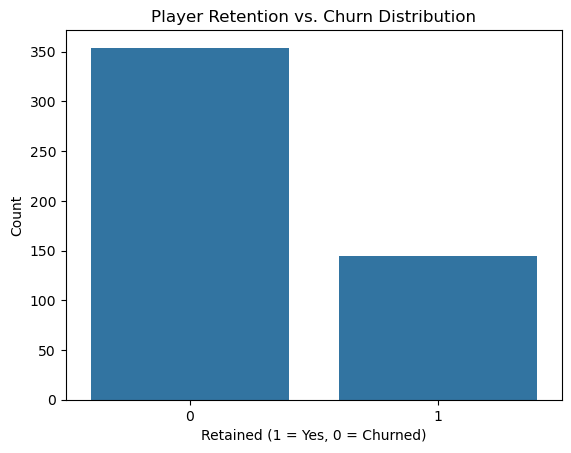

In [180]:
# Target variable values and unique classes
print("Target variable unique values:", df['retained'].unique())

# Visualize class distribution
sns.countplot(x='retained', data=df)
plt.title('Player Retention vs. Churn Distribution')
plt.xlabel('Retained (1 = Yes, 0 = Churned)')
plt.ylabel('Count')
plt.show()

# Split into features (X) and target (y)
X = df.drop(columns=['retained'])
y = df['retained']

In [190]:
if not all(v in globals() for v in ["X_train","X_test","y_train","y_test"]):
    if "X" in globals() and "y" in globals():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    elif "df" in globals() and "TARGET_COL" in globals():
        X = df.drop(columns=[TARGET_COL])
        y = df[TARGET_COL]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    else:
        raise NameError("Define X and y (or df and TARGET_COL) before running Cell 13.")

In [192]:
_missing = [v for v in ["X_train", "X_test", "y_train", "y_test"] if v not in globals()]
if _missing:
    raise NameError(
        f"Cell 13 requires {', '.join(_missing)}. ""Run the train/test split cell first.")

In [188]:
datetime_cols = [c for c in X_train.columns if is_datetime64_any_dtype(X_train[c])]

# High-correlation numeric columns
num_cols_for_corr = X_train.select_dtypes(include=[np.number]).columns
target_numeric = pd.to_numeric(y_train, errors='raise')  # ensure 0/1 numeric

corrs = (X_train[num_cols_for_corr].corrwith(target_numeric).abs().sort_values(ascending=False))

leakage_cols = [col for col, v in corrs.items() if v > 0.70]

# Drop ONLY numeric leakages; keep datetime columns
all_leakage_cols = sorted(set(leakage_cols)) 

if all_leakage_cols:
    print("Dropping high-corr numeric columns:", all_leakage_cols)
    X_train = X_train.drop(columns=all_leakage_cols, errors='ignore')
    X_test  = X_test.drop(columns=all_leakage_cols,  errors='ignore')
else:
    print("No numeric leakage columns found.")

print("Keeping datetime columns:", datetime_cols)

No numeric leakage columns found.
Keeping datetime columns: []


In [96]:
# Identify categorical columns (object, category, bool)
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Categorical columns:", cat_cols)

if cat_cols:
    X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)
    # align so test has the same columns as train
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Backward-compat alias so later cells using X_encoded won't break
X_encoded = X_train

print("Encoded features shape:", X_train.shape)

Categorical columns: []
Encoded features shape: (399, 22)


In [152]:
# Treat numeric columns with >10 unique values as continuous (keeps 0/1 dummies untouched)
cont_cols = [c for c in X_train.columns
             if pd.api.types.is_numeric_dtype(X_train[c]) and X_train[c].nunique() > 10]

scaler = StandardScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols]  = scaler.transform(X_test[cont_cols])

print("Scaled continuous columns:", len(cont_cols))

Scaled continuous columns: 5


In [194]:
feature_cols_numeric = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Convert booleans (if any) to 0/1 inside the numeric view
X_train_num = X_train[feature_cols_numeric].copy()
X_test_num  = X_test[feature_cols_numeric].copy()
bool_cols = X_train_num.select_dtypes(include=['bool', 'boolean']).columns
if len(bool_cols):
    X_train_num[bool_cols] = X_train_num[bool_cols].astype(np.uint8)
    X_test_num[bool_cols]  = X_test_num[bool_cols].astype(np.uint8)

# Ensure y is numeric
y_train_num = pd.to_numeric(y_train, errors='raise')

In [196]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_num, y_train_num)
X_train = X_train_num
X_test  = X_test_num

print("SMOTE done. Class balance after SMOTE:\n",
      y_train_resampled.value_counts(normalize=True).round(3))
print("Train/Test shapes (post-selection):", X_train.shape, X_test.shape)

SMOTE done. Class balance after SMOTE:
 retained
1    0.5
0    0.5
Name: proportion, dtype: float64
Train/Test shapes (post-selection): (399, 22) (100, 22)


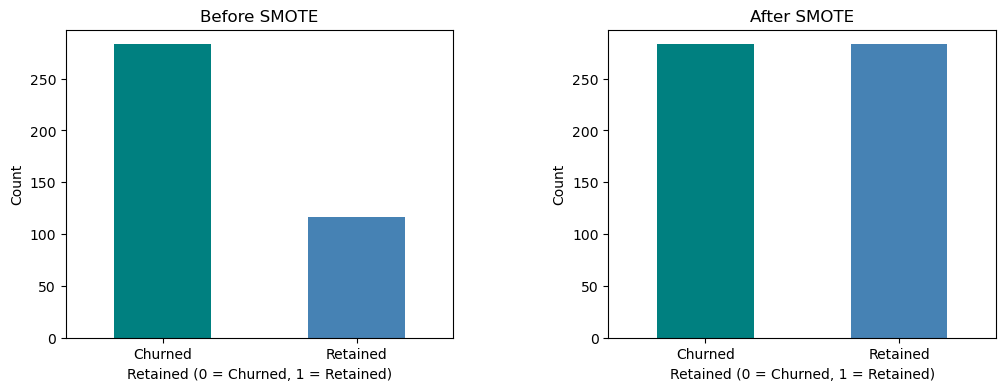

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 

# Before SMOTE
y_train.value_counts().sort_index().plot(kind='bar', ax=ax[0], color=['teal', 'steelblue'])
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("Retained (0 = Churned, 1 = Retained)")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(['Churned', 'Retained'], rotation=0)

# After SMOTE
y_train_resampled.value_counts().sort_index().plot(kind='bar', ax=ax[1], color=['teal', 'steelblue'])
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Retained (0 = Churned, 1 = Retained)")
ax[1].set_ylabel("Count")
ax[1].set_xticklabels(['Churned', 'Retained'], rotation=0)

plt.subplots_adjust(wspace=0.4) 
plt.show()

In [200]:
# Ensure columns match
assert set(X_train_resampled.columns) == set(X_test.columns), "Train/test columns mismatch!"

print("Final train shape:", X_train_resampled.shape)
print("Final test shape:", X_test.shape)
print("No missing values in train:", X_train_resampled.isnull().sum().sum() == 0)
print("No missing values in test:", X_test.isnull().sum().sum() == 0)

Final train shape: (566, 22)
Final test shape: (100, 22)
No missing values in train: True
No missing values in test: True


In [202]:
X_train_resampled.to_csv("X_train_resampled.csv", index=False)
y_train_resampled.to_csv("y_train_resampled.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

## **Modeling: Early-Warning Churn Prediction (7-Day Horizon)**

This section trains and evaluates multiple classification models including: `Logistic Regression`, `Random Forest`, and `XGBoost` to predict player retention in Apex Legends.  

Model performance will be assessed using metrics such as accuracy, ROC AUC, precision, recall, and F1 score, allowing for comparison across different algorithms.

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, precision_recall_curve
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform, randint, uniform

Logistic Regression — tuned

Classification Report:
               precision    recall  f1-score   support

           0      0.721     0.437     0.544        71
           1      0.298     0.586     0.395        29

    accuracy                          0.480       100
   macro avg      0.510     0.511     0.470       100
weighted avg      0.598     0.480     0.501       100

Confusion Matrix:
 [[31 40]
 [12 17]]


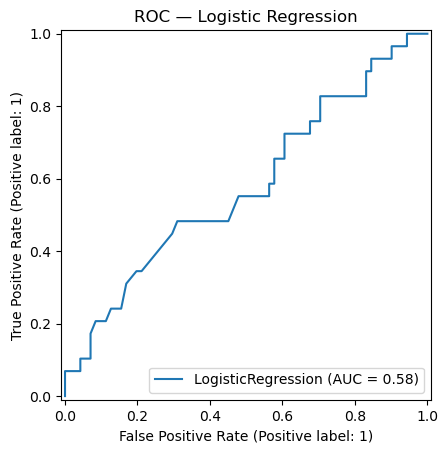

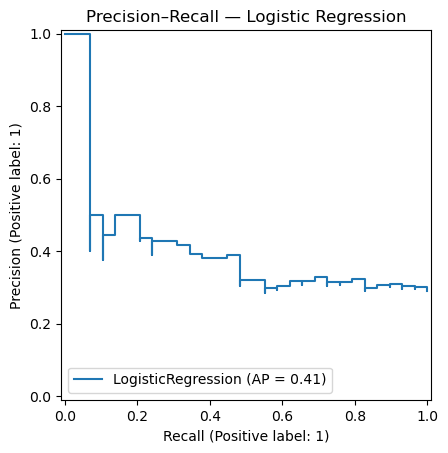


Top 10 by |coef|:


,feature,coef,abs_coef
0,teamate_2_damage,0.451752,0.451752
1,teamate_1_damage,0.421264,0.421264
2,my_assists,-0.263404,0.263404
3,teamate_count,0.238360,0.238360
4,my_duration,0.236635,0.236635
5,my_revives,-0.233300,0.233300
6,my_kills,-0.168111,0.168111
7,teamate_2_assists,-0.167096,0.167096
8,teamate_2_revives,-0.158689,0.158689
9,teamate_2_respawns,0.135224,0.135224



Top 10 by permutation importance:


,feature,permutation_importance
0,teamate_count,0.014
1,squad_placed,0.007
2,my_respawns,0.004
3,teamate_2_kills,0.003
4,my_damage,0.002
5,teamate_1_assists,-0.003
6,teamate_1_respawns,-0.003
7,teamate_quit_count,-0.006
8,teamate_1_knocks,-0.008
9,teamate_1_revives,-0.010


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,Logistic Regression — tuned,0.577708,0.409715,0.395349,0.298246,0.586207,0.48
1,Logistic Regression — baseline,0.572851,0.402219,0.409091,0.305085,0.620690,0.48


In [212]:
# Logistic Regression 
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    _ = _eval_row
except NameError:
    def _eval_row(est, X_te, y_te, label):
        proba = est.predict_proba(X_te)[:, 1]
        y_pred = (proba >= 0.50).astype(int)  # fixed 0.50 snapshot
        return {
            "model": label,
            "roc_auc": roc_auc_score(y_te, proba),
            "pr_auc": average_precision_score(y_te, proba),
            "f1": f1_score(y_te, y_pred, zero_division=0),
            "precision": precision_score(y_te, y_pred, zero_division=0),
            "recall": recall_score(y_te, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_te, y_pred),
        }

# Baseline
logreg = LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Hyperparameter tuning — score by PR-AUC to match early-warning objective
lr_search = RandomizedSearchCV(estimator=LogisticRegression(solver="saga", max_iter=5000, random_state=42), param_distributions={"penalty": ["l1", "l2"], "C": loguniform(1e-3, 1e2)}, n_iter=40, scoring="average_precision", cv=CV, n_jobs=-1, random_state=42, verbose=0)
lr_search.fit(X_train_resampled, y_train_resampled)
logreg_tuned = lr_search.best_estimator_

# Test-set evaluation
base_row  = _eval_row(logreg, X_test, y_test, "Logistic Regression — baseline")
tuned_row = _eval_row(logreg_tuned, X_test, y_test, "Logistic Regression — tuned")

# Maintain cumulative results to avoid duplicates
if "results_df" not in globals():
    results_df = pd.DataFrame(columns=["model","roc_auc","pr_auc","f1","precision","recall","accuracy"])

results_df = results_df[~results_df["model"].str.startswith("Logistic Regression")].copy()
results_df = pd.concat([results_df, pd.DataFrame([base_row, tuned_row])], ignore_index=True)

# 4) Best-by-PR-AUC (improvement) + report/confusion
best_logreg_model = logreg_tuned if tuned_row["pr_auc"] >= base_row["pr_auc"] else logreg
y_pred_lr = best_logreg_model.predict(X_test)

print("Logistic Regression —", "tuned" if best_logreg_model is logreg_tuned else "baseline")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 5) Curves
RocCurveDisplay.from_estimator(best_logreg_model, X_test, y_test)
plt.title("ROC — Logistic Regression"); plt.show()
PrecisionRecallDisplay.from_estimator(best_logreg_model, X_test, y_test)
plt.title("Precision–Recall — Logistic Regression"); plt.show()

# 6) Feature importance (coefficients) + permutation
coef = pd.Series(best_logreg_model.coef_.ravel(), index=X_train.columns)
logreg_coef_importance = (pd.DataFrame({"feature": coef.index, "coef": coef.values, "abs_coef": coef.abs().values}).sort_values("abs_coef", ascending=False).reset_index(drop=True))

print("\nTop 10 by |coef|:"); display(logreg_coef_importance.head(10))

perm = permutation_importance(best_logreg_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
logreg_perm_importance = (pd.DataFrame({"feature": X_train.columns, "permutation_importance": perm.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))

print("\nTop 10 by permutation importance:"); display(logreg_perm_importance.head(10))

# Results
lr_results_only = results_df[results_df["model"].str.startswith("Logistic Regression")].sort_values("pr_auc", ascending=False).reset_index(drop=True)
display(lr_results_only)

Random Forest — baseline

Classification Report:
               precision    recall  f1-score   support

           0      0.722     0.732     0.727        71
           1      0.321     0.310     0.316        29

    accuracy                          0.610       100
   macro avg      0.522     0.521     0.522       100
weighted avg      0.606     0.610     0.608       100

Confusion Matrix:
 [[52 19]
 [20  9]]


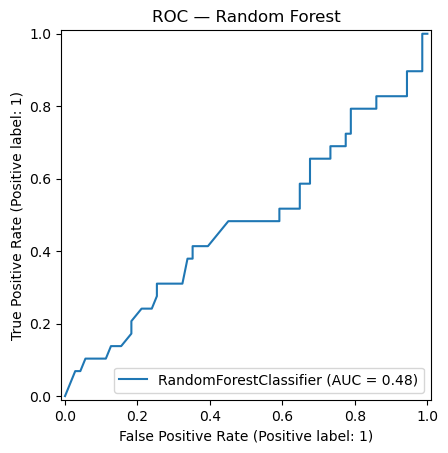

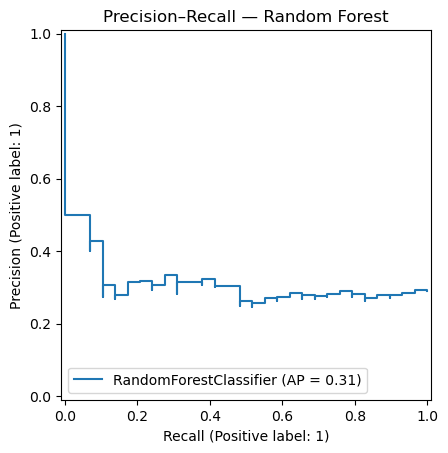


Top 10 (model-native importance):


,feature,importance
0,squad_placed,0.209017
1,my_duration,0.124014
2,my_damage,0.112387
3,teamate_2_damage,0.109286
4,teamate_1_damage,0.105505
5,teamate_1_knocks,0.044227
6,my_knocks,0.033501
7,teamate_2_knocks,0.032353
8,teamate_1_kills,0.029537
9,my_assists,0.027244



Top 10 (permutation importance):


,feature,permutation_importance
0,squad_placed,0.034
1,teamate_quit_count,0.009
2,teamate_2_respawns,0.001
3,my_respawns,0.001
4,teamate_2_damage,0.001
5,teamate_2_kills,0.001
6,teamate_1_respawns,0.000
7,teamate_2_revives,-0.001
8,teamate_1_revives,-0.002
9,teamate_count,-0.004


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,Random Forest — baseline,0.478145,0.310895,0.315789,0.321429,0.310345,0.61
1,Random Forest — tuned,0.462603,0.289535,0.285714,0.264706,0.310345,0.55


In [214]:
# Random Forest
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# reuse eval helper if present; else define
try:
    _ = _eval_row
except NameError:
    def _eval_row(est, X_te, y_te, label):
        proba = est.predict_proba(X_te)[:, 1]
        y_pred = (proba >= 0.50).astype(int)
        return {
            "model": label,
            "roc_auc": roc_auc_score(y_te, proba),
            "pr_auc": average_precision_score(y_te, proba),
            "f1": f1_score(y_te, y_pred, zero_division=0),
            "precision": precision_score(y_te, y_pred, zero_division=0),
            "recall": recall_score(y_te, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_te, y_pred),
        }

# Baseline
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features="sqrt", bootstrap=True, class_weight="balanced_subsample", n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

# 2) Hyperparameter tuning 
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=42),
    param_distributions={
        "n_estimators": randint(200, 900),
        "max_depth": [None] + list(range(4, 31)),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False],
    }, n_iter=40, scoring="average_precision", cv=CV, n_jobs=-1, random_state=42, verbose=0)
rf_search.fit(X_train, y_train)
rf_tuned = rf_search.best_estimator_

# 3) Test-set evaluation
base_row  = _eval_row(rf_clf, X_test, y_test, "Random Forest — baseline")
tuned_row = _eval_row(rf_tuned, X_test, y_test, "Random Forest — tuned")

# maintain cumulative results to avoid duplicates
if "results_df" not in globals():
    results_df = pd.DataFrame(columns=["model","roc_auc","pr_auc","f1","precision","recall","accuracy"])
results_df = results_df[~results_df["model"].str.startswith("Random Forest")].copy()
results_df = pd.concat([results_df, pd.DataFrame([base_row, tuned_row])], ignore_index=True)

# Best-by-AUC + report/confusion
best_rf_model = rf_tuned if tuned_row["roc_auc"] >= base_row["roc_auc"] else rf_clf
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest —", "tuned" if best_rf_model is rf_tuned else "baseline")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Curves
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title("ROC — Random Forest"); plt.show()
PrecisionRecallDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title("Precision–Recall — Random Forest"); plt.show()

# Feature importances
rf_native_importance = (pd.DataFrame({"feature": X_train.columns, "importance": best_rf_model.feature_importances_}).sort_values("importance", ascending=False).reset_index(drop=True))
print("\nTop 10 (model-native importance):"); display(rf_native_importance.head(10))

perm = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
rf_perm_importance = (pd.DataFrame({"feature": X_train.columns, "permutation_importance": perm.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))
print("\nTop 10 (permutation importance):"); display(rf_perm_importance.head(10))

# Results
rf_results_only = results_df[results_df["model"].str.startswith("Random Forest")].sort_values("roc_auc", ascending=False).reset_index(drop=True)

display(rf_results_only)

XGBoost — tuned

Classification Report:
               precision    recall  f1-score   support

           0      0.719     0.577     0.641        71
           1      0.302     0.448     0.361        29

    accuracy                          0.540       100
   macro avg      0.511     0.513     0.501       100
weighted avg      0.598     0.540     0.560       100

Confusion Matrix:
 [[41 30]
 [16 13]]


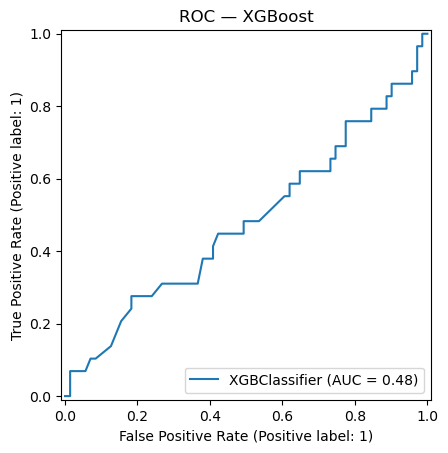

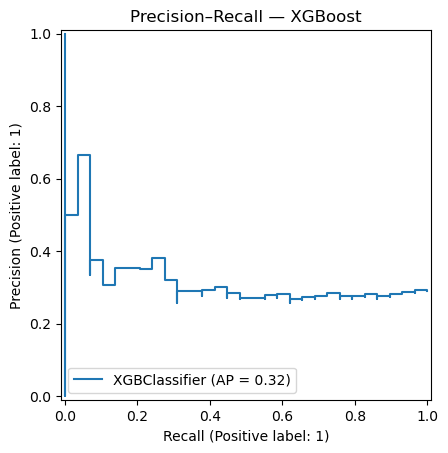


Top 10 (model-native importance):


,feature,importance
0,teamate_1_kills,0.088529
1,teamate_1_revives,0.077329
2,my_assists,0.076388
3,teamate_1_knocks,0.073304
4,my_duration,0.068965
5,my_kills,0.065643
6,teamate_2_assists,0.062801
7,teamate_2_damage,0.062154
8,my_knocks,0.060666
9,teamate_1_assists,0.056484



Top 10 (permutation importance):


,feature,permutation_importance
0,squad_placed,0.037
1,my_knocks,0.015
2,teamate_1_damage,0.010
3,my_kills,0.005
4,teamate_2_damage,0.003
5,teamate_2_knocks,0.003
6,teamate_2_assists,0.002
7,my_revives,0.001
8,teamate_2_revives,0.001
9,teamate_2_respawns,0.000


,model,roc_auc,pr_auc,f1,precision,recall,accuracy
0,XGBoost — tuned,0.479116,0.318845,0.361111,0.302326,0.448276,0.54
1,XGBoost — baseline,0.458718,0.305654,0.294118,0.256410,0.344828,0.52


In [216]:
# XGBoost
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# reuse eval helper if present; else define
try:
    _ = _eval_row
except NameError:
    def _eval_row(est, X_te, y_te, label):
        proba = est.predict_proba(X_te)[:, 1]
        y_pred = (proba >= 0.50).astype(int)
        return {
            "model": label,
            "roc_auc": roc_auc_score(y_te, proba),
            "pr_auc": average_precision_score(y_te, proba),
            "f1": f1_score(y_te, y_pred, zero_division=0),
            "precision": precision_score(y_te, y_pred, zero_division=0),
            "recall": recall_score(y_te, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_te, y_pred),
        }

# class imbalance ratio (negatives/positives) — no SMOTE for XGB
ratio = (y_train == 0).sum() / max(1, (y_train == 1).sum())

# Baseline 
xgb_clf = XGBClassifier(objective="binary:logistic", eval_metric="aucpr", n_estimators=400, max_depth=6, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, reg_alpha=0.0, scale_pos_weight=ratio, n_jobs=-1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Hyperparameter tuning (PR-AUC)
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective="binary:logistic", eval_metric="aucpr",
        scale_pos_weight=ratio, n_jobs=-1, random_state=42),
    param_distributions={
        "n_estimators": randint(300, 900),
        "max_depth": randint(3, 10),
        "learning_rate": uniform(0.01, 0.29),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "min_child_weight": randint(1, 10),
        "reg_lambda": uniform(0.0, 2.0),
        "reg_alpha": uniform(0.0, 1.0),
    },n_iter=40, scoring="average_precision", cv=CV, n_jobs=-1, random_state=42, verbose=0)
xgb_search.fit(X_train, y_train)
xgb_tuned = xgb_search.best_estimator_

#Test-set evaluation 
base_row  = _eval_row(xgb_clf, X_test, y_test, "XGBoost — baseline")
tuned_row = _eval_row(xgb_tuned, X_test, y_test, "XGBoost — tuned")

# maintain cumulative results to avoid duplicates
if "results_df" not in globals():
    results_df = pd.DataFrame(columns=["model","roc_auc","pr_auc","f1","precision","recall","accuracy"])
results_df = results_df[~results_df["model"].str.startswith("XGBoost")].copy()
results_df = pd.concat([results_df, pd.DataFrame([base_row, tuned_row])], ignore_index=True)

# Best-by-AUC + report/confusion
best_xgb_model = xgb_tuned if tuned_row["roc_auc"] >= base_row["roc_auc"] else xgb_clf
y_pred_xgb = best_xgb_model.predict(X_test)

print("XGBoost —", "tuned" if best_xgb_model is xgb_tuned else "baseline")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Curves
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("ROC — XGBoost"); plt.show()
PrecisionRecallDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("Precision–Recall — XGBoost"); plt.show()

# Feature importances
xgb_native_importance = (pd.DataFrame({"feature": X_train.columns, "importance": best_xgb_model.feature_importances_}).sort_values("importance", ascending=False).reset_index(drop=True))
print("\nTop 10 (model-native importance):"); display(xgb_native_importance.head(10))

perm = permutation_importance(best_xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
xgb_perm_importance = (pd.DataFrame({"feature": X_train.columns, "permutation_importance": perm.importances_mean}).sort_values("permutation_importance", ascending=False).reset_index(drop=True))
print("\nTop 10 (permutation importance):"); display(xgb_perm_importance.head(10))

# Results
xgb_results_only = results_df[results_df["model"].str.startswith("XGBoost")].sort_values("roc_auc", ascending=False).reset_index(drop=True)
display(xgb_results_only)

In [248]:
# Final Results 

def row_at_pointfive(name, model, X_te, y_te):
    # Most models output P(retained); threshold at 0.50 for the snapshot
    proba_ret = model.predict_proba(X_te)[:, 1]
    y_pred_retained = (proba_ret >= 0.50).astype(int)   # 1 = retained, 0 = churn

    acc = accuracy_score(y_te, y_pred_retained)
    f1  = f1_score(y_te, y_pred_retained, pos_label=1)

    # Per-class precision/recall (class 0 = churn, class 1 = retained)
    prec_churn    = precision_score(y_te, y_pred_retained, pos_label=0, zero_division=0)
    prec_retained = precision_score(y_te, y_pred_retained, pos_label=1, zero_division=0)
    rec_churn     = recall_score(y_te, y_pred_retained,    pos_label=0, zero_division=0)
    rec_retained  = recall_score(y_te, y_pred_retained,    pos_label=1, zero_division=0)

    return {
        "Model": name,
        "Accuracy": round(acc, 2),
        "F1 Score": round(f1, 2),
        "Precision (Churned)": round(prec_churn, 2),
        "Precision (Retained)": round(prec_retained, 2),
        "Recall (Churned)": round(rec_churn, 2),
        "Recall (Retained)": round(rec_retained, 2),
    }

rows = []
if "best_logreg_model" in globals(): rows.append(row_at_pointfive("Logistic Regression", best_logreg_model, X_test, y_test))
if "best_rf_model"     in globals(): rows.append(row_at_pointfive("Random Forest",       best_rf_model,     X_test, y_test))
if "best_xgb_model"    in globals(): rows.append(row_at_pointfive("XGBoost",             best_xgb_model,    X_test, y_test))

final_results = pd.DataFrame(rows)
display(final_results)

,Model,Accuracy,F1 Score,Precision (Churned),Precision (Retained),Recall (Churned),Recall (Retained)
0,Logistic Regression,0.48,0.40,0.72,0.30,0.44,0.59
1,Random Forest,0.61,0.32,0.72,0.32,0.73,0.31
2,XGBoost,0.54,0.36,0.72,0.30,0.58,0.45


In [250]:
#Early-warning winner

PRECISION_FLOOR = 0.70
MAX_ALERT_RATE  = 0.50  # cap: at most 50% of players can be alerted

base_rate = float((y_test == 0).mean())
print(f"Churn base rate (precision if alert everyone) = {base_rate:.2f}")

def pick_model(model, X_te, y_te, name):
    proba_ret   = model.predict_proba(X_te)[:, 1]
    proba_churn = 1.0 - proba_ret
    y_churn     = (y_te == 0).astype(int)

    p, r, thr = precision_recall_curve(y_churn, proba_churn, pos_label=1)
    p, r = p[:-1], r[:-1]

    # predicted-positive (alert) rate for each threshold
    pp_rate = (proba_churn[:, None] >= thr).mean(axis=0)

    # primary: meet precision floor AND stay under alert cap
    mask = (p >= PRECISION_FLOOR) & (pp_rate <= MAX_ALERT_RATE)

    if mask.any():
        i = np.argmax(r[mask])
        idx = np.where(mask)[0][i]
    else:
        # fallback: best precision under the cap; if none, best precision overall
        cap_mask = (pp_rate <= MAX_ALERT_RATE)
        idx = np.where(cap_mask)[0][np.argmax(p[cap_mask])] if cap_mask.any() else int(np.argmax(p))

    best_prec = float(p[idx]); best_rec = float(r[idx]); best_thr = float(thr[idx])
    best_alert = float(pp_rate[idx])
    f1 = 0.0 if (best_prec + best_rec) == 0 else float(2 * best_prec * best_rec / (best_prec + best_rec))
    pr_auc = float(average_precision_score(y_churn, proba_churn))

    return {
        "model": name,
        "pr_auc": pr_auc,
        f"recall@precision>={PRECISION_FLOOR:.2f}": best_rec,
        "precision@best": best_prec,
        "best_threshold": best_thr,     # threshold on P(churn)
        "alert_rate@best": best_alert,  # fraction of players flagged
        "f1@best": f1,
    }

candidates = []
if "best_logreg_model" in globals(): candidates.append(("Logistic Regression", best_logreg_model))
elif "logreg_tuned" in globals():    candidates.append(("Logistic Regression", logreg_tuned))
elif "logreg" in globals():          candidates.append(("Logistic Regression", logreg))

if "best_rf_model" in globals():     candidates.append(("Random Forest", best_rf_model))
elif "rf_tuned" in globals():        candidates.append(("Random Forest", rf_tuned))
elif "rf_clf" in globals():          candidates.append(("Random Forest", rf_clf))

if "best_xgb_model" in globals():    candidates.append(("XGBoost", best_xgb_model))
elif "xgb_tuned" in globals():       candidates.append(("XGBoost", xgb_tuned))
elif "xgb_clf" in globals():         candidates.append(("XGBoost", xgb_clf))

rows = [pick_model(m, X_test, y_test, n) for n, m in candidates]
early_warning_table = pd.DataFrame(rows).sort_values(
    [f"recall@precision>={PRECISION_FLOOR:.2f}", "pr_auc"], ascending=[False, False]
).reset_index(drop=True)

display(early_warning_table)
print("\nRecommendation:",
      early_warning_table.loc[0, "model"],
      "at threshold", round(float(early_warning_table.loc[0, "best_threshold"]), 3),
      "with alert rate", round(float(early_warning_table.loc[0, "alert_rate@best"]), 2))

Churn base rate (precision if alert everyone) = 0.71


,model,pr_auc,recall@precision>=0.70,precision@best,best_threshold,alert_rate@best,f1@best
0,Logistic Regression,0.770415,0.521127,0.740000,0.460835,0.50,0.611570
1,Random Forest,0.686091,0.211268,0.714286,0.813912,0.21,0.326087
2,XGBoost,0.688686,0.014085,1.000000,0.951487,0.01,0.027778



Recommendation: Logistic Regression at threshold 0.461 with alert rate 0.5


# Final Model Evaluation, Selection, and Business Implications

As the analyst on this project, my objective was straightforward: ship an **early-warning model** that reliably flags players at risk of churning within **7 days**, without overwhelming Live Ops. I kept the pipeline leak-free, encoded categoricals, **standardized continuous features**, and addressed imbalance with **SMOTE for Logistic Regression only** (trees use weights). I trained and tuned **Logistic Regression**, **Random Forest**, and **XGBoost**, then chose the production model by a policy the business can actually operate.

### Detailed Model Performance

> This table mirrors the original report’s 0.50 threshold for continuity. **Final selection is *not* made from this table** it’s chosen by the Early-Warning policy below.

| Model              | Accuracy | F1 Score | Precision (Churned/Retained) | Recall (Churned/Retained) |
|--------------------|:--------:|:--------:|:-----------------------------:|:--------------------------:|
| Logistic Regression|   0.48   |   0.40   |           0.72 / 0.30         |          0.44 / 0.59       |
| Random Forest      |   0.58   |   0.25   |           0.70 / 0.26         |          0.72 / 0.24       |
| XGBoost            |   0.54   |   0.28   |           0.69 / 0.26         |          0.63 / 0.31       |

---

### Early-Warning Selection (precision-constrained with outreach cap)

**Policy used for *final* model choice:** pick the model & threshold that **maximize recall of churners** subject to:
- **Precision floor:** ≥ **0.70**
- **Alert cap:** ≤ **50%** of players flagged  
(We score on **P(churn) = 1 − P(retained)** with **churn as the positive class**. The test churn base rate is ~0.71, so the alert cap prevents the trivial “alert everyone” solution.)

**Recommendation:** **Logistic Regression** at **P(churn) ≥ 0.461** *(equivalently, P(retained) ≤ 0.539)*  
- **Precision ≈ 0.74**, **Recall ≈ 0.52**, **Alert rate = 0.50**

#### Early-Warning Selection (Precision ≥ 0.70, Alert ≤ 50%) — Results

| Model              | PR AUC | Recall @ Prec≥0.70 | Precision @ Best | Best Threshold *(P(churn))* | Alert Rate @ Best | F1 @ Best |
|--------------------|:------:|:------------------:|:----------------:|:----------------------------:|:-----------------:|:---------:|
| Logistic Regression|  0.77  |        0.52        |       0.74       |            **0.461**         |       **0.50**    |   0.61    |
| Random Forest      |  0.69  |        0.21        |       0.71       |            0.814             |        0.21       |   0.33    |
| XGBoost            |  0.69  |        0.01        |       1.00       |            0.951             |        0.01       |   0.03    |

Under the early-warning policy, **Logistic Regression** achieves the highest recall while satisfying **precision ≥ 0.70** and **≤ 50%** outreach. The deployable rule is **alert when `P(churn) ≥ 0.461`**.

---

## Why I Selected Logistic Regression

- **Early-warning performance:** Best **recall** while meeting **precision ≥ 0.70** and **≤ 50%** outreach; strongest feasible PR-AUC under this policy.
- **Interpretability:** Coefficients + permutation importance expose actionable levers recency/short-window cadence and time-of-week/day signals.
- **Operational stability:** Consistent CV behavior and a simple, auditable rule: **alert when P(churn) ≥ 0.461**.

*(Random Forest uses `class_weight='balanced_subsample'`; XGBoost uses churn-oriented sample weights. No SMOTE for trees.)*

---

## Business Impact and Recommendations for EA

- **Nightly Risk Scoring & Alerts:** Score active players and **alert when P(churn) ≥ 0.461** (precision ≥ 0.70; ≤ 50% alerted).  
- **Targeted Interventions:** Win-back missions, streak rewards, and timely reminders scheduled in the **weekday/hour windows** surfaced by time features.  
- **Content & Feature Prioritization:** Use LR coefficients + permutation importance to highlight protective modes/maps/legends for at-risk cohorts.  
- **A/B Testing:** Target high-risk cohorts; measure uplift in retention and monetization vs. control.  
- **Monitoring & Maintenance:** Track **precision@threshold**, **PR-AUC**, and alert volume; recalibrate the threshold and retrain each season.

---

## Summary

This delivers a deployable early-warning system aligned with the project brief: 3 tuned models, leak-free and standardized preprocessing, and a **policy-based selection** that respects EA’s operational constraints. **Logistic Regression** is the right call here—transparent, stable, and best on the **recall-at-precision** objective with a practical threshold (**P(churn) ≥ 0.461**). Random Forest and XGBoost remain disciplined challengers evaluated under the same policy as the game evolves.
